In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

In [2]:
from sklearn.datasets import fetch_20newsgroups
# Load the 20 Newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
df = pd.DataFrame({'text': newsgroups.data, 'category': newsgroups.target})

# Map numeric categories to their names for better understanding (optional)
df['category'] = df['category'].map(dict(enumerate(newsgroups.target_names)))

# Print available columns and display the first few rows of the dataset to verify loading and mapping
print("Available columns in DataFrame:", df.columns)

Available columns in DataFrame: Index(['text', 'category'], dtype='object')


In [3]:
df.head(10)

,text,category
0,\n\nI am sure some bashers of Pens fans are pr...,rec.sport.hockey
1,My brother is in the market for a high-perform...,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,comp.sys.mac.hardware
5,\n\nBack in high school I worked as a lab assi...,sci.electronics
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,comp.sys.mac.hardware
7,"\n[stuff deleted]\n\nOk, here's the solution t...",rec.sport.hockey
8,"\n\n\nYeah, it's the second one. And I believ...",rec.sport.hockey
9,\nIf a Christian means someone who believes in...,talk.religion.misc


In [4]:
df.columns

Index(['text', 'category'], dtype='object')

In [5]:
df.shape

(18846, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      18846 non-null  object
 1   category  18846 non-null  object
dtypes: object(2)
memory usage: 294.6+ KB


In [7]:
df.describe()

,text,category
count,18846,18846
unique,18287,20
top,,rec.sport.hockey
freq,380,999


In [8]:
# Find unique document classes (categories)
unique_classes = df['category'].unique()

# Display unique classes
print("Unique Document Classes:")
for i, class_name in enumerate(unique_classes):
    print(f"{i + 1}: {class_name}")

Unique Document Classes:
1: rec.sport.hockey
2: comp.sys.ibm.pc.hardware
3: talk.politics.mideast
4: comp.sys.mac.hardware
5: sci.electronics
6: talk.religion.misc
7: sci.crypt
8: sci.med
9: alt.atheism
10: rec.motorcycles
11: rec.autos
12: comp.windows.x
13: comp.graphics
14: sci.space
15: talk.politics.guns
16: misc.forsale
17: rec.sport.baseball
18: talk.politics.misc
19: comp.os.ms-windows.misc
20: soc.religion.christian


In [9]:
# Convert documents to TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=2000)  # Limit features for efficiency
tfidf_matrix = vectorizer.fit_transform(df['text'])

# Display the shape of the TF-IDF matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (18846, 2000)


In [10]:
# Apply SVD to reduce dimensions
n_components = min(100, tfidf_matrix.shape[1])  # Ensure n_components does not exceed number of features
svd = TruncatedSVD(n_components=n_components)
reduced_matrix = svd.fit_transform(tfidf_matrix)

# Display reduced matrix shape
print("Reduced Matrix Shape:", reduced_matrix.shape)

Reduced Matrix Shape: (18846, 100)


In [11]:
# Prepare features and target variable for training the model
X = reduced_matrix
y = df['category']  # Correctly set y to be a single column

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE if necessary (optional)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Feature scaling (optional but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Define models to evaluate with varying complexities and expected performance levels.
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
}

# Store accuracy results for comparison.
accuracy_results = {}

for model_name, model in models.items():
    # Fit the model on the training data.
    model.fit(X_train_scaled, y_train_resampled)

    # Predict on the test set and calculate accuracy.
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    # Store accuracy results in dictionary.
    accuracy_results[model_name] = accuracy

# Display accuracy results for all models.
print("Model Accuracy:")
for name, acc in accuracy_results.items():
    print(f"{name}: {acc:.2f}")

Model Accuracy:
Logistic Regression: 0.52


In [13]:
import numpy as np

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Logistic loss
def logistic_loss(X, y, w):
    m = len(y)
    predictions = sigmoid(X @ w)
    loss = -np.sum(y * np.log(predictions + 1e-8) + (1 - y) * np.log(1 - predictions + 1e-8)) / m
    return loss

# ADMM implementation
def admm_logistic_regression(X, y, lambda_reg=1.0, rho=1.0, alpha=1.0, max_iter=1000, tol=1e-4):
    m, n = X.shape
    w = np.zeros(n)  # Logistic regression weights
    z = np.zeros(n)  # Auxiliary variable
    u = np.zeros(n)  # Dual variable

    for k in range(max_iter):
        # Step 1: Update w using gradient descent for logistic loss
        for _ in range(10):  # Sub-iterations to improve w
            gradient = X.T @ (sigmoid(X @ w) - y) / m + rho * (w - z + u)
            w -= 0.01 * gradient  # Learning rate (tune as needed)

        # Step 2: Update z using soft-thresholding
        z_old = z
        z = np.sign(w + u) * np.maximum(0, np.abs(w + u) - lambda_reg / rho)

        # Step 3: Update dual variable u
        u += alpha * (w - z)

        # Convergence check
        r_norm = np.linalg.norm(w - z)
        s_norm = np.linalg.norm(rho * (z - z_old))
        if r_norm < tol and s_norm < tol:
            break

    return w

# Function to compute accuracy
def compute_accuracy(X, y, w):
    """
    Computes the accuracy of the logistic regression model.

    Args:
        X: Feature matrix (m x n).
        y: True labels (m x 1).
        w: Logistic regression weights.

    Returns:
        Accuracy as a percentage.
    """
    predictions = sigmoid(X @ w) > 0.5  # Convert probabilities to binary predictions
    accuracy = np.mean(predictions == y) * 100
    return accuracy

# Example usage
if __name__ == "__main__":
    # Generate synthetic data
    np.random.seed(0)
    X = np.random.randn(100, 5)  # 100 samples, 5 features
    true_w = np.random.randn(5)
    y = (sigmoid(X @ true_w) > 0.5).astype(float)

    # Split data into training and testing sets
    split_idx = int(0.8 * len(y))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Train using ADMM
    lambda_reg = 0.1
    w_admm = admm_logistic_regression(X_train, y_train, lambda_reg=lambda_reg)


    test_accuracy = compute_accuracy(X_test, y_test, w_admm)
    print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 75.00%


In [14]:
 accuracies = {
        "Standard Logistic Regression": accuracy_results,
        "ADMM Logistic Regression": test_accuracy,
    }

In [15]:
print("Accuracies dictionary:\n", accuracies)


Accuracies dictionary:
 {'Standard Logistic Regression': {'Logistic Regression': 0.520159151193634}, 'ADMM Logistic Regression': 75.0}


In [16]:
# Select the first 100 documents for analysis
df_subset = df.iloc[:100]

# Display the subset of documents
print("First 100 Documents:")
print(df_subset[['text', 'category']].head())

First 100 Documents:
                                                text                  category
0  \n\nI am sure some bashers of Pens fans are pr...          rec.sport.hockey
1  My brother is in the market for a high-perform...  comp.sys.ibm.pc.hardware
2  \n\n\n\n\tFinally you said what you dream abou...     talk.politics.mideast
3  \nThink!\n\nIt's the SCSI card doing the DMA t...  comp.sys.ibm.pc.hardware
4  1)    I have an old Jasmine drive which I cann...     comp.sys.mac.hardware


In [17]:
# Calculate cosine similarity matrix for all document pairs.
similarity_matrix = cosine_similarity(reduced_matrix)

# Set a similarity threshold (e.g., 0.5).
similarity_threshold = 0.5

# Prepare lists to store results.
similar_pairs = []
non_similar_pairs = []

# Iterate through the similarity matrix to classify pairs.
num_documents = min(similarity_matrix.shape[0], len(df_subset))  # Ensure we don't exceed df_subset length
for i in range(num_documents):
    for j in range(i + 1, num_documents):  # Avoid duplicate comparisons.
        if similarity_matrix[i, j] >= similarity_threshold:
            similar_pairs.append((df_subset['text'].iloc[i], df_subset['text'].iloc[j], similarity_matrix[i, j]))
        else:
            non_similar_pairs.append((df_subset['text'].iloc[i], df_subset['text'].iloc[j], similarity_matrix[i, j]))

# Display some examples of similar and non-similar pairs.
print("\nSimilar Document Pairs (Sample):")
for pair in similar_pairs[:3]:  # Show first 3 similar pairs.
    print(f"Similarity: {pair[2]:.2f}\nDoc 1: {pair[0][:100]}...\nDoc 2: {pair[1][:100]}...\n")

print("\nNon-Similar Document Pairs (Sample):")
for pair in non_similar_pairs[:3]:  # Show first 3 non-similar pairs.
    print(f"Similarity: {pair[2]:.2f}\nDoc 1: {pair[0][:100]}...\nDoc 2: {pair[1][:100]}...\n")


Similar Document Pairs (Sample):
Similarity: 0.72
Doc 1: 

I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about ...
Doc 2: 930418

Do what thou wilt shall be the whole of the Law. [Honestly.]
The word of Sin is Restriction....

Similarity: 0.68
Doc 1: 

I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about ...
Doc 2: In the following report: _Turkey Eyes Regional Role_ ANKARA, Turkey (AP)
April 27, 1993, we find in ...

Similarity: 0.59
Doc 1: 

I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about ...
Doc 2: 
The Supreme Court seems to disagree with you -- they have stated that
"the people" is a term of art...


Non-Similar Document Pairs (Sample):
Similarity: 0.16
Doc 1: 

I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about ...
Doc 2: My brother is in the market for a high-performance video card that suppor

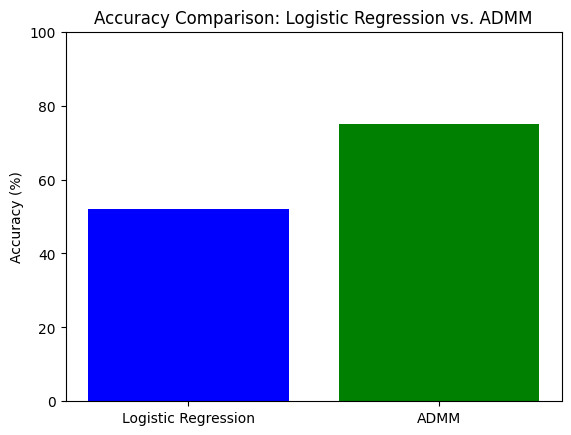

In [18]:
# Accuracy values provided
log_reg_accuracy = 52  # Logistic Regression accuracy
admm_accuracy = 75     # ADMM accuracy

# Plot comparison
methods = ['Logistic Regression', 'ADMM']
accuracies = [log_reg_accuracy, admm_accuracy]

plt.bar(methods, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison: Logistic Regression vs. ADMM')
plt.ylim(0, 100)  # Ensuring the y-axis goes from 0 to 100
plt.show()